Importando NLTK (Natural Language Toolkit) y descargando los recursos necesarios para el análisis de sentimiento.

In [242]:
import nltk
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to
[nltk_data]    |     C:\Users\julio\AppData\Roaming\nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to
[nltk_data]    |     C:\Users\julio\AppData\Roaming\nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     C:\Users\julio\AppData\Roaming\nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     C:\Users\julio\AppData\Roaming\nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     C:\Users\julio\AppData\Roaming\nltk_data...
[nltk_data]    | 

True

General imports

In [243]:
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from scipy import stats
from sklearn import metrics
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import matplotlib.pyplot as plt
import string
import re
import emoji
import random
from pandas_profiling import ProfileReport
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer
from pattern.text.en import singularize, lemma
from wordcloud import WordCloud
from wordcloud import ImageColorGenerator
from wordcloud import STOPWORDS
from transformers import BertTokenizer,BertModel, AdamW, get_linear_schedule_with_warmup
import tensorflow
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy,BinaryCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy,BinaryAccuracy
from tensorflow.keras.utils import plot_model

Cargando dataset de entrenamiento y test

In [244]:
# Cargando datos
train = pd.read_csv('./train.csv', encoding='utf8')
test = pd.read_csv('./test.csv', encoding='utf8')

Reporte del dataset de entrenamiento

In [245]:
profile = ProfileReport(train)
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Gráficos exploratorios

<AxesSubplot:title={'center':'Frecuencia de location'}, xlabel='location', ylabel='Frecuencia'>

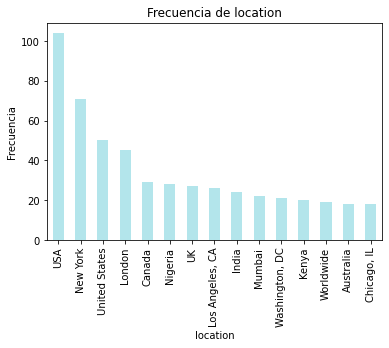

In [246]:
plt.title('Frecuencia de location')
plt.xlabel('location')
plt.ylabel('Frecuencia')
train['location'].value_counts().head(15).plot.bar(color="#B3E5EB")

<AxesSubplot:title={'center':'Frecuencia de keyword'}, xlabel='keyword', ylabel='Frecuencia'>

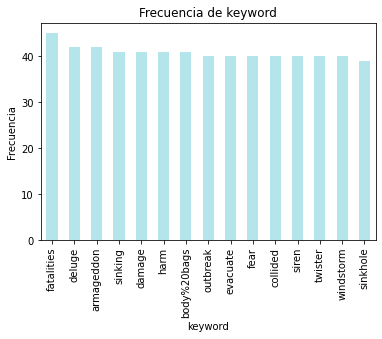

In [247]:
plt.title('Frecuencia de keyword')
plt.xlabel('keyword')
plt.ylabel('Frecuencia')
train['keyword'].value_counts().head(15).plot.bar(color="#B3E5EB")

<AxesSubplot:title={'center':'Histograma de target'}, xlabel='target', ylabel='count'>

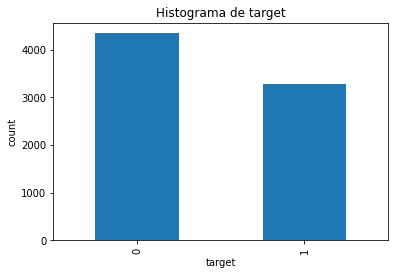

In [248]:
plt.title('Histograma de target')
plt.xlabel('target')
plt.ylabel('count')
train['target'].value_counts().plot.bar()

Comparando dataset de entrenamiento y test

In [249]:
print(train.columns)
print(test.columns)

Index(['id', 'keyword', 'location', 'text', 'target'], dtype='object')
Index(['id', 'keyword', 'location', 'text'], dtype='object')


<AxesSubplot:title={'center':'Frecuencia de location'}, xlabel='location', ylabel='Frecuencia'>

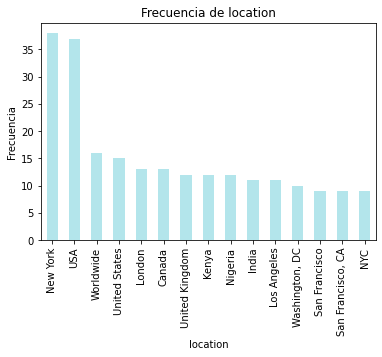

In [250]:
plt.title('Frecuencia de location')
plt.xlabel('location')
plt.ylabel('Frecuencia')
test['location'].value_counts().head(15).plot.bar(color="#B3E5EB")

<AxesSubplot:title={'center':'Frecuencia de keyword'}, xlabel='keyword', ylabel='Frecuencia'>

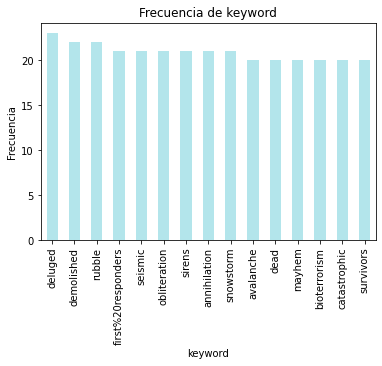

In [251]:
plt.title('Frecuencia de keyword')
plt.xlabel('keyword')
plt.ylabel('Frecuencia')
test['keyword'].value_counts().head(15).plot.bar(color="#B3E5EB")

### Limpieza de Datos

Convirtiendo a minúsculas

In [252]:
for i in range(len(train)):
    train.loc[i,'text'] = train.loc[i,'text'].lower()

for i in range(len(test)):
    test.loc[i,'text'] = test.loc[i,'text'].lower()

In [253]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,our deeds are the reason of this #earthquake m...,1
1,4,NaN,NaN,forest fire near la ronge sask. canada,1
2,5,NaN,NaN,all residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,just got sent this photo from ruby #alaska as ...,1


In [254]:
test.head()

,id,keyword,location,text
0,0,NaN,NaN,just happened a terrible car crash
1,2,NaN,NaN,"heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,apocalypse lighting. #spokane #wildfires
4,11,NaN,NaN,typhoon soudelor kills 28 in china and taiwan


Quitando urls

In [255]:
#Quitar las urls
for i in range(len(train)):
    train.loc[i,'text'] = re.sub(r'((http|https)\:\/\/)?[a-zA-Z0-9\.\/\?\:@\-_=#]+\.([a-zA-Z]){2,6}([a-zA-Z0-9\.\&\/\?\:@\-_=#])*', "", train.loc[i,'text'])

for i in range(len(test)):
    test.loc[i,'text'] = re.sub(r'((http|https)\:\/\/)?[a-zA-Z0-9\.\/\?\:@\-_=#]+\.([a-zA-Z]){2,6}([a-zA-Z0-9\.\&\/\?\:@\-_=#])*', '', test.loc[i,'text'])


In [256]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,our deeds are the reason of this #earthquake m...,1
1,4,NaN,NaN,forest fire near la ronge sask. canada,1
2,5,NaN,NaN,all residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,just got sent this photo from ruby #alaska as ...,1


In [257]:
test.head()

,id,keyword,location,text
0,0,NaN,NaN,just happened a terrible car crash
1,2,NaN,NaN,"heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,apocalypse lighting. #spokane #wildfires
4,11,NaN,NaN,typhoon soudelor kills 28 in china and taiwan


Eliminando signos de puntuación y caracteres especiales (@, #, $, %, etc.)

In [258]:
#Se eliminan los signos de puntuacion
for i in range(len(train)):
    train.loc[i,'text'] = train.loc[i,'text'].translate(str.maketrans(string.punctuation, ' ' * len(string.punctuation)))
    

for i in range(len(test)):
    test.loc[i,'text'] = test.loc[i,'text'].translate(str.maketrans(string.punctuation, ' ' * len(string.punctuation)))

In [259]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,our deeds are the reason of this earthquake m...,1
1,4,NaN,NaN,forest fire near la ronge sask canada,1
2,5,NaN,NaN,all residents asked to shelter in place are ...,1
3,6,NaN,NaN,13 000 people receive wildfires evacuation or...,1
4,7,NaN,NaN,just got sent this photo from ruby alaska as ...,1


In [260]:
test.head()

,id,keyword,location,text
0,0,NaN,NaN,just happened a terrible car crash
1,2,NaN,NaN,heard about earthquake is different cities s...
2,3,NaN,NaN,there is a forest fire at spot pond geese are...
3,9,NaN,NaN,apocalypse lighting spokane wildfires
4,11,NaN,NaN,typhoon soudelor kills 28 in china and taiwan


Definiendo stopwords en idioma inglés
Quitando las stopwords (the, a, an, etc.)

In [261]:
#Ref: https://www.delftstack.com/howto/python/remove-stop-words-in-python/#:~:text=The%20nlkt%20(Natural%20Language%20Processing,the%20list%20from%20this%20library.
#Quitar las stopwords
stopWords = stopwords.words('english')

for i in range(len(train)):
    train.loc[i,'text'] = ' '.join(word for word in train.loc[i,'text'].split() if word not in stopWords)

for i in range(len(test)):
    test.loc[i,'text'] = ' '.join(word for word in test.loc[i,'text'].split() if word not in stopWords)

In [262]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,deeds reason earthquake may allah forgive us,1
1,4,NaN,NaN,forest fire near la ronge sask canada,1
2,5,NaN,NaN,residents asked shelter place notified officer...,1
3,6,NaN,NaN,13 000 people receive wildfires evacuation ord...,1
4,7,NaN,NaN,got sent photo ruby alaska smoke wildfires pou...,1


In [263]:
test.head()

,id,keyword,location,text
0,0,NaN,NaN,happened terrible car crash
1,2,NaN,NaN,heard earthquake different cities stay safe ev...
2,3,NaN,NaN,forest fire spot pond geese fleeing across str...
3,9,NaN,NaN,apocalypse lighting spokane wildfires
4,11,NaN,NaN,typhoon soudelor kills 28 china taiwan


Removiendo emojis

In [264]:
# Ref: https://stackoverflow.com/questions/33404752/removing-emojis-from-a-string-in-python
# Se eliminan emojis
emoj = re.compile("["
                    u"\U0001F600-\U0001F64F"  # emoticons
                    u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                    u"\U0001F680-\U0001F6FF"  # transport & map symbols
                    u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                    u"\U00002500-\U00002BEF"  # chinese char
                    u"\U00002702-\U000027B0"
                    u"\U00002702-\U000027B0"
                    u"\U000024C2-\U0001F251"
                    u"\U0001f926-\U0001f937"
                    u"\U00010000-\U0010ffff"
                    u"\u2640-\u2642"
                    u"\u2600-\u2B55"
                    u"\u200d"
                    u"\u23cf"
                    u"\u23e9"
                    u"\u231a"
                    u"\ufe0f"  # dingbats
                    u"\u3030"
                    "]+", flags=re.UNICODE)

for i in range(len(train)):
    train.loc[i, 'text'] = emoj.sub(r'', train.loc[i, 'text'])

for i in range(len(test)):
    test.loc[i, 'text'] = emoj.sub(r'', test.loc[i, 'text'])


In [265]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,deeds reason earthquake may allah forgive us,1
1,4,NaN,NaN,forest fire near la ronge sask canada,1
2,5,NaN,NaN,residents asked shelter place notified officer...,1
3,6,NaN,NaN,13 000 people receive wildfires evacuation ord...,1
4,7,NaN,NaN,got sent photo ruby alaska smoke wildfires pou...,1


In [266]:
test.head()

,id,keyword,location,text
0,0,NaN,NaN,happened terrible car crash
1,2,NaN,NaN,heard earthquake different cities stay safe ev...
2,3,NaN,NaN,forest fire spot pond geese fleeing across str...
3,9,NaN,NaN,apocalypse lighting spokane wildfires
4,11,NaN,NaN,typhoon soudelor kills 28 china taiwan


Quitando números excepto el 911

In [267]:
#Quitar numeros, se considera dejar el 911 ya que es un numero representativo en EEUU y puede ser de utilidad
for i in range(len(train)):
    train.loc[i,'text'] = re.sub(r'#\S+|\d+', lambda match: match.group(0) if match.group(0).startswith('911') else '', train.loc[i,'text'])

for i in range(len(test)):
    test.loc[i,'text'] = re.sub(r'#\S+|\d+', lambda match: match.group(0) if match.group(0).startswith('911') else '', test.loc[i,'text'])

In [268]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,deeds reason earthquake may allah forgive us,1
1,4,NaN,NaN,forest fire near la ronge sask canada,1
2,5,NaN,NaN,residents asked shelter place notified officer...,1
3,6,NaN,NaN,people receive wildfires evacuation orders c...,1
4,7,NaN,NaN,got sent photo ruby alaska smoke wildfires pou...,1


In [269]:
test.head()

,id,keyword,location,text
0,0,NaN,NaN,happened terrible car crash
1,2,NaN,NaN,heard earthquake different cities stay safe ev...
2,3,NaN,NaN,forest fire spot pond geese fleeing across str...
3,9,NaN,NaN,apocalypse lighting spokane wildfires
4,11,NaN,NaN,typhoon soudelor kills china taiwan


Cambiando %20 por espacio en columna target

In [270]:
# replace %20 text in keyword column with space
train['keyword'] = train['keyword'].str.replace('%20', ' ')
test['keyword'] = test['keyword'].str.replace('%20', ' ')

Categorizando columnas location y keyword

In [271]:
#train['keyword'] = train['keyword'].astype('category')
#train['keyword'] = train['keyword'].cat.codes
#train['location'] = train['location'].astype('category')
#train['location'] = train['location'].cat.codes
#test['keyword'] = test['keyword'].astype('category')
#test['keyword'] = test['keyword'].cat.codes
#test['location'] = test['location'].astype('category')
#test['location'] = test['location'].cat.codes

Creando wordcloud

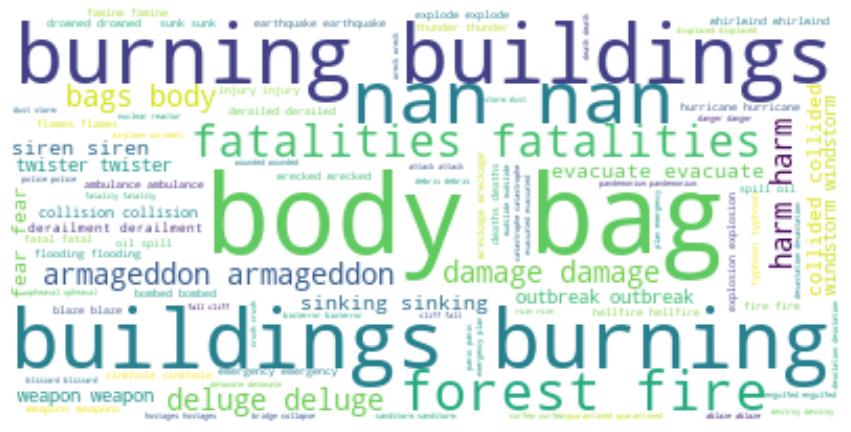

In [272]:
stopwords = set(STOPWORDS)
keywords = " ".join(review for review in train.keyword.astype(str))
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(keywords)
plt.figure( figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### Clasificando las palabras

Frecuencia de tweets de desastres

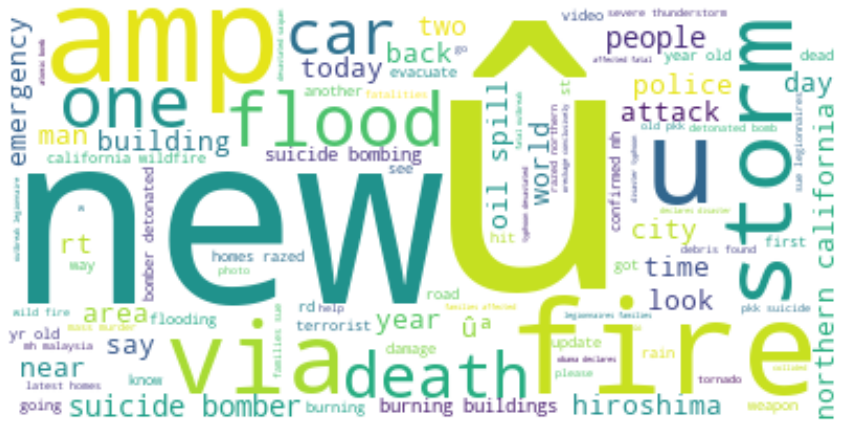

In [273]:
disaster_freq = train[train['target'] == 1]
disaster_words = []
for i in range(len(disaster_freq)):
    text = disaster_freq.iloc[i]['text'].split()
    for word in text:
        disaster_words.append(word)

keywords = " ".join(review for review in disaster_words)
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(keywords)
plt.figure( figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Frecuencia de tweets de no desastres

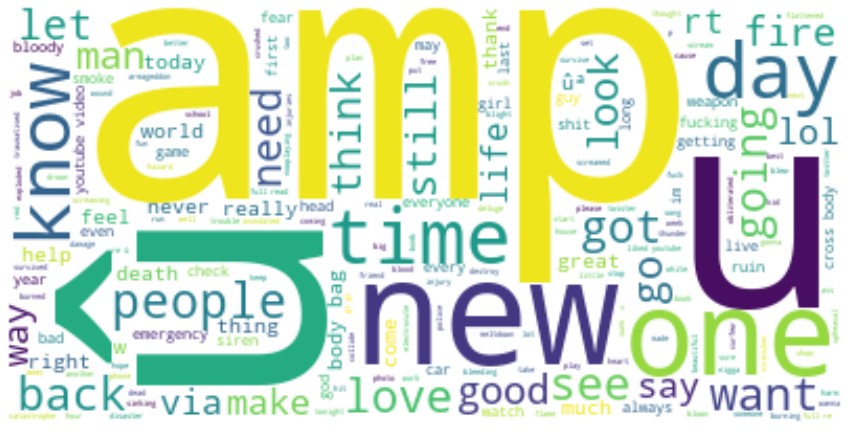

In [274]:
not_disaster_freq = train[train['target'] == 0]
not_disaster_words = []
for i in range(len(not_disaster_freq)):
    text = not_disaster_freq.iloc[i]['text'].split()
    for word in text:
        not_disaster_words.append(word)

keywords = " ".join(review for review in not_disaster_words)
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(keywords)
plt.figure( figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Analizando bigramas

<AxesSubplot:xlabel='frequency', ylabel='bigram'>

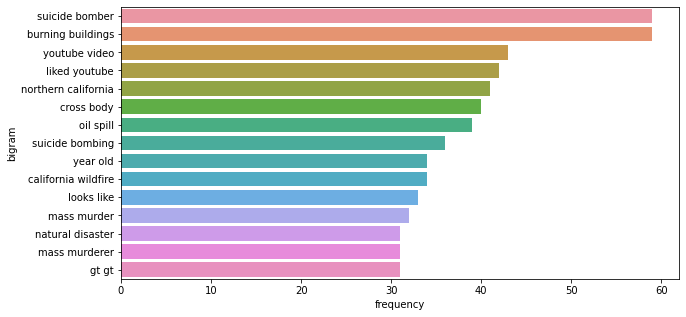

In [278]:
# https://towardsdatascience.com/text-analysis-basics-in-python-443282942ec5
def get_bigrams(text):
    count_vectorizer = CountVectorizer(ngram_range=(2, 2))
    ngrams = count_vectorizer.fit_transform(text)
    count_values = ngrams.toarray().sum(axis=0)
    vocab = count_vectorizer.vocabulary_
    df_ngram = pd.DataFrame(sorted([(count_values[i], k) for k, i in vocab.items(
    )], reverse=True)).rename(columns={0: 'frequency', 1: 'bigram'})
    return df_ngram

plt.figure(figsize=(10, 5))
bigrams = get_bigrams(train['text'])
x = bigrams['frequency'][:15]
y = bigrams['bigram'][:15]
sns.barplot(x=x, y=y)


Analizando trigramas

In [ ]:
# https://towardsdatascience.com/text-analysis-basics-in-python-443282942ec5
def get_trigrams(text):
    count_vectorizer = CountVectorizer(ngram_range=(3, 3))
    ngrams = count_vectorizer.fit_transform(text)
    count_values = ngrams.toarray().sum(axis=0)
    vocab = count_vectorizer.vocabulary_
    df_ngram = pd.DataFrame(sorted([(count_values[i], k) for k, i in vocab.items(
    )], reverse=True)).rename(columns={0: 'frequency', 1: 'trigrams'})
    return df_ngram

plt.figure(figsize=(10, 5))
trigrams = get_trigrams(train['text'])
x = trigrams['frequency'][:15]
y = trigrams['trigrams'][:15]
sns.barplot(x=x, y=y)

Utilizando Vader como corpus de entrenamiento para el análisis de sentimiento

In [276]:
# Referencia: https://akladyous.medium.com/sentiment-analysis-using-vader-c56bcffe6f24
nltk.download('vader_lexicon')
sentimentAnalyzer = SentimentIntensityAnalyzer()
def get_scores(sentence):
    score = sentimentAnalyzer.polarity_scores(sentence)
    score = score['compound']
    return score

def set_real(score):
    if score < -0.5:
        return 'negative'
    elif score > 0.5:
        return 'positive'
    else:
        return 'neutral'

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\julio\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [277]:
train['score'] = train['text'].apply(get_scores)
train['sentiment'] = train['score'].apply(set_real)

test['score'] = test['text'].apply(get_scores)
test['sentiment'] = test['score'].apply(set_real)